### Code from the course page:

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
import os

In [ ]:
file_id = "lalalalalal"  ## file-link to google drive
output_file = "downloaded_file.zip"
!gdown --id $file_id -O $output_file
print(f"File {output_file} downloaded successfully!")

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-zqi7Y_NYHNFdbii4MEYz46LZ8g4Pe62
From (redirected): https://drive.google.com/uc?id=1-zqi7Y_NYHNFdbii4MEYz46LZ8g4Pe62&confirm=t&uuid=99af9441-ada1-4e6b-8dd1-f7c75cf5c80d
To: /content/downloaded_file.zip
100% 4.93G/4.93G [00:55<00:00, 89.4MB/s]
File downloaded_file.zip downloaded successfully!


In [ ]:
# Create a folder to extract the files
extract_path = "/content/extracted_files"
os.makedirs(extract_path, exist_ok=True)
# Extract the zip file
!unzip -q "$output_file" -d "$extract_path"
print(f"File extracted to {extract_path}")

File extracted to /content/extracted_files


In [ ]:
# List files in the extracted folder
extracted_files = os.listdir(extract_path + '/Potsdam-GeoTif')
#print("Extracted files:")
#extracted_files

In [ ]:
# Other libraries
import numpy as np
import glob
import random
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
!pip install rasterio
import rasterio as rio
from rasterio.transform import xy
from tensorflow.keras import layers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 77.7 MB/s eta 0:00:00


In [ ]:
PathToGeoTiffFile = "./extracted_files/Potsdam-GeoTif" # Define the path to your GeoTif file

In [ ]:
blob = PathToGeoTiffFile + '/0000028672-0000020608.tif'

In [ ]:
img = rio.open(blob)
img_array = img.read()
imtransform = img.transform
nRows = img_array.shape[1]
ncols = img_array.shape[2]
Bands = img_array.shape[0]
img_array = img_array.reshape(Bands, nRows*ncols).T
img_array = img_array.reshape( nRows,ncols, Bands)
plt.figure(figsize=(24,8))
plt.imshow(img_array[:,:,0:3]/255)
plt.title('Image in RGB')

In [ ]:
img = rio.open(blob)
img_array = img.read() # results should be (bands, height, width)

plt.figure(figsize=(8, 8))
elevation_band = img_array[4]  # elevation ought to be found in the 5th band (index 4)
im = plt.imshow(elevation_band, cmap='terrain')

plt.title('Elevation Band')
plt.colorbar(im)
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

class_names = ["Impervious surface", "Building", "Tree(s)","Low vegetation", "Car", "Clutter/Background"]
class_colors = ["#E1101B",           "#aa7EB8", "#345238" , "#4DAF4A" ,       "#FF7F00","#FFFF33"  ]
cmap = ListedColormap(class_colors)

plt.figure(figsize=(8, 8))
target_band = img_array[5]

im = plt.imshow(target_band, cmap=cmap, vmin=0, vmax=5)

cbar = plt.colorbar(im, ticks=np.arange(6))
cbar.ax.set_yticklabels(class_names)

plt.title('Target Label Band')
plt.show()


### TASK 1:

In [ ]:
sampled_files = random.sample(extracted_files, 5000)
random.shuffle(sampled_files)

five_folds = [sampled_files[0:1000],
              sampled_files[1000:2000],
              sampled_files[2000:3000],
              sampled_files[3000:4000],
              sampled_files[4000:5000]]

In [ ]:
def create_tfrecord(file_list, output_path, data_path):
    with tf.io.TFRecordWriter(output_path) as writer:
        for file_name in file_list:
            file_path = os.path.join(data_path, file_name)
            with rio.open(file_path) as src:

                bands = src.read()  # we get an array with 6 bands, height and width
                inputs = bands[:5]  # red, green, blue, ir and elevation
                target = bands[5]   # labels (1 band)
                target = bands[5].astype(np.uint8)

            inputs_bytes = inputs.tobytes()
            target_bytes = target.tobytes()

            # all data is now converted from numpy to bytes for storage. fix
            # a dict and save the data as features mapped to the dict...
            feature = {
                'inputs': tf.train.Feature(bytes_list=tf.train.BytesList(value=[inputs_bytes])),
                'target': tf.train.Feature(bytes_list=tf.train.BytesList(value=[target_bytes])),
                'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[int(inputs.shape[1])])),
                'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[int(inputs.shape[2])]))
            }

            example_image = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example_image.SerializeToString())


In [ ]:
PathToGeoTiffFile = "./extracted_files/Potsdam-GeoTif"

In [ ]:
create_tfrecord(five_folds[0], "training_data1.tfrecord", PathToGeoTiffFile)
create_tfrecord(five_folds[1], "training_data2.tfrecord", PathToGeoTiffFile)
create_tfrecord(five_folds[2], "training_data3.tfrecord", PathToGeoTiffFile)
create_tfrecord(five_folds[3], "validation_data.tfrecord", PathToGeoTiffFile)
create_tfrecord(five_folds[4], "test_data.tfrecord", PathToGeoTiffFile)

### TASK 2:

In [ ]:
def parse_tfrecord(example, use_ir=True, use_elevation=True):
    feature_description = {
        'inputs': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)

    height = example['height']
    width = example['width']

    inputs = tf.io.decode_raw(example['inputs'], tf.float32)
    inputs = tf.reshape(inputs, (5, height, width))

    bands = []
    bands.extend([0, 1, 2])
    if use_ir:
        bands.append(3)
    if use_elevation:
        bands.append(4)

    # ahh transpose is necessary to go from (band, width, height) to (W,H,B)
    inputs = tf.transpose(tf.gather(inputs, bands, axis=0), [1, 2, 0])
    inputs = tf.image.resize(inputs, (224, 224))

    target = tf.io.decode_raw(example['target'], tf.uint8)
    target = tf.reshape(target, (height, width))
    target = tf.image.resize(target[..., tf.newaxis], (224, 224), method='nearest')
    target = tf.squeeze(target, axis=-1)
    target = tf.cast(target, tf.int32)

    # this converts target labels to "one_hot" so that categorical_crossentropy can be used
    target = tf.one_hot(target, depth=6)

    return inputs, target

def augment(inputs, target):
    inputs = tf.image.random_flip_left_right(inputs)
    inputs = tf.image.random_flip_up_down(inputs)
    inputs = tf.image.rot90(inputs, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    return inputs, target

In [ ]:
def get_dataset(tfrecord_path, batch_size=32, shuffle=True, augment_data=False):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(lambda x: parse_tfrecord(x, use_ir=True,
                                                   use_elevation=False),
                           num_parallel_calls=tf.data.AUTOTUNE)
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def build_model():
    inputs = tf.keras.Input(shape=(224, 224, 4))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    outputs = tf.keras.layers.Conv2D(6, (3, 3), activation='softmax', padding="same")(x)
    return tf.keras.Model(inputs, outputs)

def train_model():
  model = build_model()
  model.compile(optimizer="adam",
                loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  train_data_1 = get_dataset("training_data1.tfrecord", augment_data=True)
  train_data_2 = get_dataset("training_data2.tfrecord", augment_data=True)
  train_data_3 = get_dataset("training_data3.tfrecord", augment_data=True)

  train_dataset = train_data_1.concatenate(train_data_2).concatenate(train_data_3)

  val_dataset = get_dataset('validation_data.tfrecord', shuffle=False)

  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_val_first.h5',
                                                     save_best_only=True,
                                                     monitor='val_loss')

  history = model.fit(train_dataset, validation_data=val_dataset,
                      epochs=20, callbacks=[checkpoint_cb])

  return history, model

In [ ]:
def plot(history):
  plt.figure()
  plt.plot(history.history["loss"], label="Training loss")
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.title("Loss")
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure()
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Accuracy')
  plt.legend()
  plt.grid()
  plt.show()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 6)         │           1,734 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,918 (11.40 KB)

 Trainable params: 2,918 (11.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
     95/Unknown 9s 67ms/step - accuracy: 0.2658 - loss: 4.9055

96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.2663 - loss: 4.8604 - val_accuracy: 0.3513 - val_loss: 1.6001
Epoch 2/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3141 - loss: 1.6631

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.3142 - loss: 1.6628 - val_accuracy: 0.4129 - val_loss: 1.4374


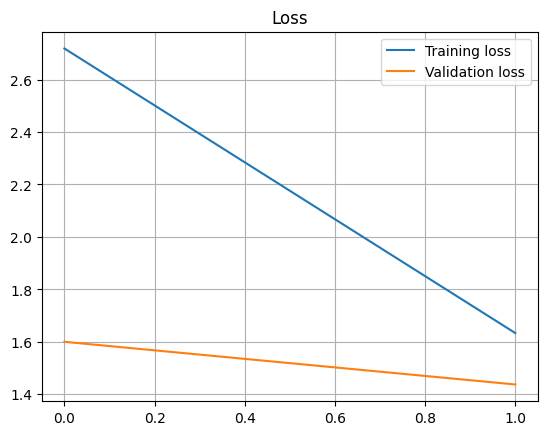

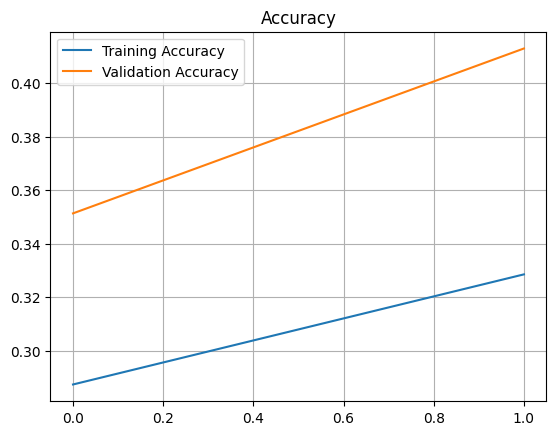

In [ ]:
history, model = train_model()
plot(history)

### TASK 3:

In [ ]:
def get_dataset(tfrecord_path, batch_size=32, shuffle=True, augment_data=False):
    # basically only changed "use_elevation=True"
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(lambda x: parse_tfrecord(x, use_ir=True,
                                                   use_elevation=True),
                           num_parallel_calls=tf.data.AUTOTUNE)
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def build_encoder_decoder_model():
    inputs = tf.keras.Input(shape=(224, 224, 5))

    firstConv = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    firstPool = layers.MaxPooling2D((2, 2))(firstConv)

    secondConv = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(firstPool)
    secondPool = layers.MaxPooling2D((2, 2))(secondConv)

    thirdConv = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(secondPool)

    convTran1 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), activation="relu", padding="same")(thirdConv)
    convTran1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(convTran1)
    convTran1 = layers.Concatenate()([convTran1, secondConv])

    convTran2 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), activation="relu", padding="same")(convTran1)
    convTran2 = layers.Concatenate()([convTran2, firstConv])

    convTran3 = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(convTran2)

    outputs = layers.Conv2D(6, (3, 3), activation='softmax', padding="same")(convTran3)

    return tf.keras.Model(inputs, outputs)


def train_model_second():
  model = build_encoder_decoder_model()
  model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'] )
  model.summary()

  train_data_1 = get_dataset("training_data1.tfrecord", augment_data=True)
  train_data_2 = get_dataset("training_data2.tfrecord", augment_data=True)
  train_data_3 = get_dataset("training_data3.tfrecord", augment_data=True)

  train_dataset = train_data_1.concatenate(train_data_2).concatenate(train_data_3)

  val_dataset = get_dataset('validation_data.tfrecord', shuffle=False)

  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('best_val_second.h5', save_best_only=True, monitor='val_loss')
  history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[checkpoint_cb])

  return history, model

def evaluation_second():

  history, model = train_model_second()
  model.load_weights('best_val_second.h5')

  plot(history)

  test_dataset = get_dataset('test_data.tfrecord', shuffle=False)
  test_loss, test_acc = model.evaluate(test_dataset)
  print(f'Test Loss: {test_loss:.2f}, Test Accuracy: {test_acc:.2f}')

  return history, model

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 5)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 224, 224, 32)   │          1,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 32)   │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 112, 112, 64)   │         36,928 │ conv2d_6[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 112, 112, 128)  │              0 │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 224, 224, 32)   │         36,896 │ concatenate[0][0]      │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 224, 224, 64)   │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 224, 224, 32)   │         18,464 │ concatenate_1[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 224, 224, 6)    │          1,734 │ conv2d_transpose_2[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 187,846 (733.77 KB)

 Trainable params: 187,846 (733.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
     96/Unknown 44s 265ms/step - accuracy: 0.3913 - loss: 6.1910

96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 319ms/step - accuracy: 0.3921 - loss: 6.1548 - val_accuracy: 0.6494 - val_loss: 1.0917
Epoch 2/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5388 - loss: 1.3247

96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.5388 - loss: 1.3246 - val_accuracy: 0.6771 - val_loss: 0.9956


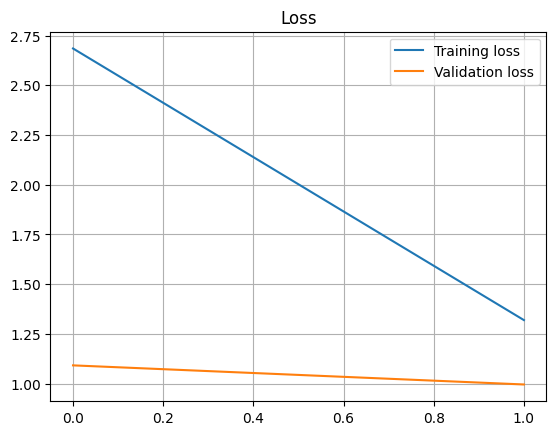

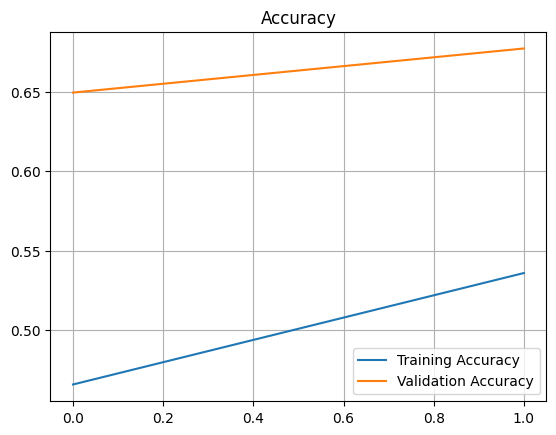

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.6825 - loss: 0.9791
Test Loss: 0.97, Test Accuracy: 0.69


In [ ]:
history_2, model_2 = evaluation_second()

### TASK 4:

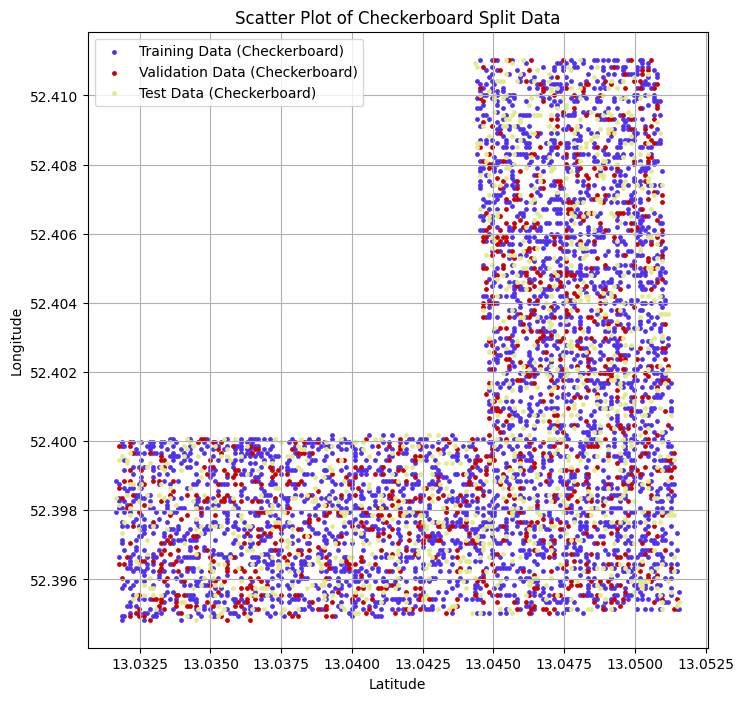

In [ ]:
all_lat, all_lon = coordinates_from_fold(random.sample(extracted_files, 5000))

size = 6
plt.figure(figsize=(8,8))
plt.scatter(all_lat[0:3000], all_lon[0:3000], label="Training Data (Checkerboard)", color='#5031F1', s=size)
plt.scatter(all_lat[3000:4000], all_lon[3000:4000], label="Validation Data (Checkerboard)", color="#CB0000", s=size)
plt.scatter(all_lat[4000:5000], all_lon[4000:5000], label="Test Data (Checkerboard)", color="#E4EA8C", s=size)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.legend()
plt.title("Scatter Plot of Checkerboard Split Data")
plt.show()

After splitting:
Training files: 4037
Validation files: 1000
Test files: 1000


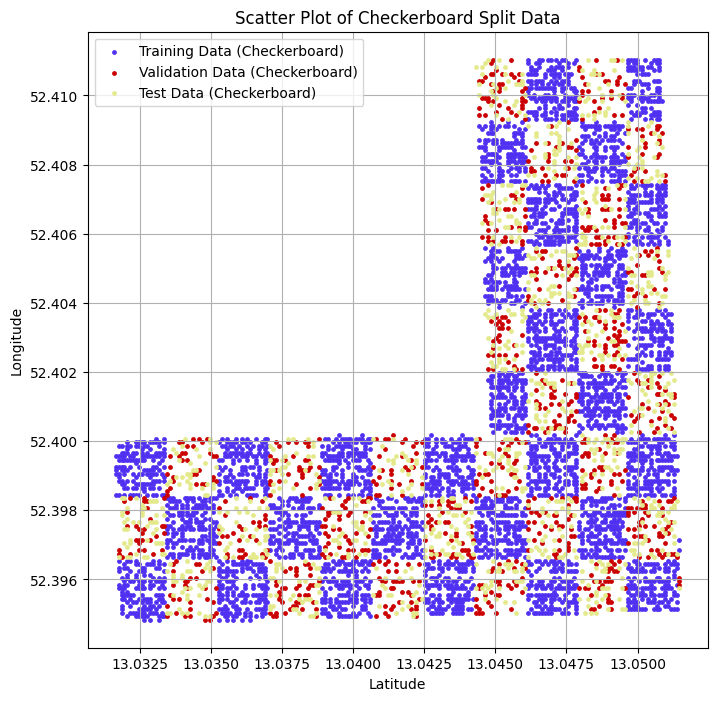

In [ ]:
def coordinates_from_fold(fold):
  x = []
  y = []
  for file in fold:
    blob = PathToGeoTiffFile + "/" + file
    with rio.open(blob) as dataset:
      width, height = dataset.width, dataset.height
      center_x = width // 2
      center_y = height // 2
      lon, lat = xy(dataset.transform, center_y, center_x)
    #print(f"Center Longitude: {lon}, Center Latitude: {lat}")
    x.append(lat)
    y.append(lon)
  return np.array(y), np.array(x)

# we need to sample more than 5000 files to make sure
# we get enough for a split into the checkerboard
all_files = random.sample(extracted_files,8000)
all_lat, all_lon = coordinates_from_fold(all_files)

# this will define the checkerboard grid
lat_min, lat_max = min(all_lat), max(all_lat)
lon_min, lon_max = min(all_lon), max(all_lon)

fraction = 0.1
delta_lat = fraction * (lat_max - lat_min)
delta_lon = fraction * (lon_max - lon_min)
delta = (delta_lat + delta_lon) / 2

def assign_checkerboard(lat, lon, delta, lat_min, lon_min):
    cell_x = int((lon - lon_min) // delta)
    cell_y = int((lat - lat_min) // delta)
    return (cell_x + cell_y) % 2 == 0

train_files, train_lat, train_lon = [], [], []
test_files, test_lat, test_lon = [], [], []

# we can now assign train or test
for file, lat, lon in zip(all_files, all_lat, all_lon):
    if assign_checkerboard(lat, lon, delta, lat_min, lon_min):
        train_files.append(file)
        train_lat.append(lat)
        train_lon.append(lon)
    else:
        test_files.append(file)
        test_lat.append(lat)
        test_lon.append(lon)

random.shuffle(train_files)
random.shuffle(test_files)

val_files = test_files[:1000]
test_files = test_files[1000:2000]

val_lat, val_lon = test_lat[:1000], test_lon[:1000]
test_lat, test_lon = test_lat[1000:2000], test_lon[1000:2000]

print("After splitting:")
print("Training files:", len(train_files))
print("Validation files:", len(val_files))
print("Test files:", len(test_files))

size = 6
plt.figure(figsize=(8,8))
plt.scatter(train_lat, train_lon, label="Training Data (Checkerboard)", color='#5031F1', s=size)
plt.scatter(val_lat, val_lon, label="Validation Data (Checkerboard)", color="#CB0000", s=size)
plt.scatter(test_lat, test_lon, label="Test Data (Checkerboard)", color="#E4EA8C", s=size)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.legend()
plt.title("Scatter Plot of Checkerboard Split Data")
plt.show()

train_files1 = train_files[0:1000]
train_files2 = train_files[1000:2000]
train_files3 = train_files[2000:3000]

#create_tfrecord(train_files1, "training_data1.tfrecord", PathToGeoTiffFile)
#create_tfrecord(train_files2, "training_data2.tfrecord", PathToGeoTiffFile)
#create_tfrecord(train_files3, "training_data3.tfrecord", PathToGeoTiffFile)
#create_tfrecord(val_files, "validation_data.tfrecord", PathToGeoTiffFile)
#create_tfrecord(test_files, "test_data.tfrecord", PathToGeoTiffFile)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 5)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 224, 224, 32)   │          1,472 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 112, 112, 32)   │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 112, 112, 64)   │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 56, 56, 64)     │              0 │ conv2d_14[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 112, 112, 64)   │         36,928 │ conv2d_15[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ conv2d_transpose_3[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 112, 112, 128)  │              0 │ conv2d_16[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 224, 224, 32)   │         36,896 │ concatenate_2[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 224, 224, 64)   │              0 │ conv2d_transpose_4[0]… │
│ (Concatenate)             │                        │                │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 224, 224, 32)   │         18,464 │ concatenate_3[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 224, 224, 6)    │          1,734 │ conv2d_transpose_5[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 187,846 (733.77 KB)

 Trainable params: 187,846 (733.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
     96/Unknown 27s 226ms/step - accuracy: 0.3315 - loss: 12.1172

96/96 ━━━━━━━━━━━━━━━━━━━━ 30s 261ms/step - accuracy: 0.3321 - loss: 12.0445 - val_accuracy: 0.5969 - val_loss: 1.3574
Epoch 2/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 24s 234ms/step - accuracy: 0.4612 - loss: 1.6717 - val_accuracy: 0.4574 - val_loss: 1.3591


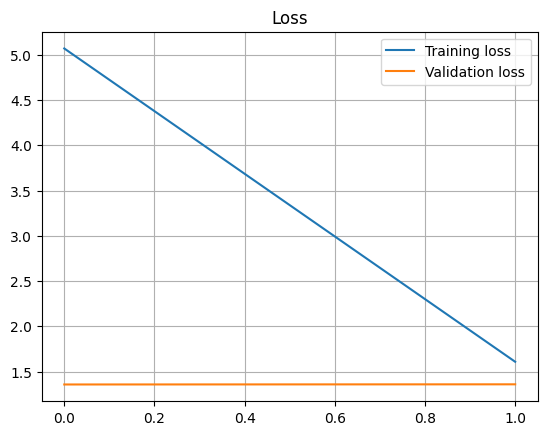

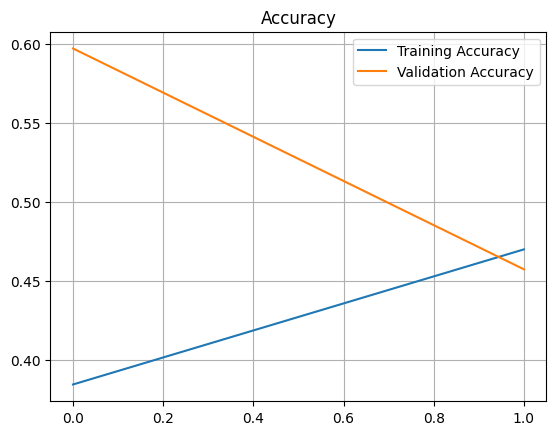

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5758 - loss: 1.4037
Test Loss: 1.41, Test Accuracy: 0.58


In [ ]:
# Run the second more advanced model again
history_2, model_2 = evaluation_second()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 4)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 224, 224, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 224, 224, 6)         │           1,734 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,918 (11.40 KB)

 Trainable params: 2,918 (11.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
     96/Unknown 9s 65ms/step - accuracy: 0.2944 - loss: 14.5837

96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.2948 - loss: 14.4971 - val_accuracy: 0.4318 - val_loss: 1.6900
Epoch 2/2
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3769 - loss: 1.8511

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.3769 - loss: 1.8511 - val_accuracy: 0.4114 - val_loss: 1.6524


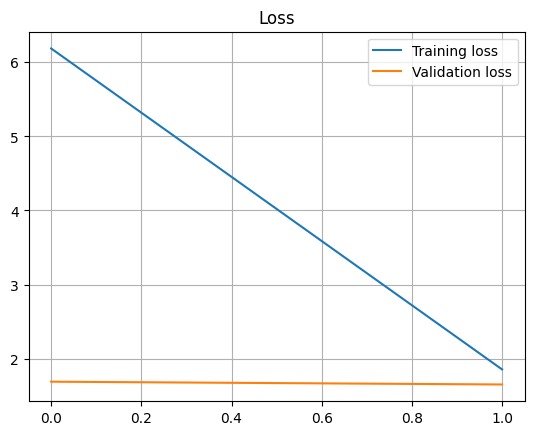

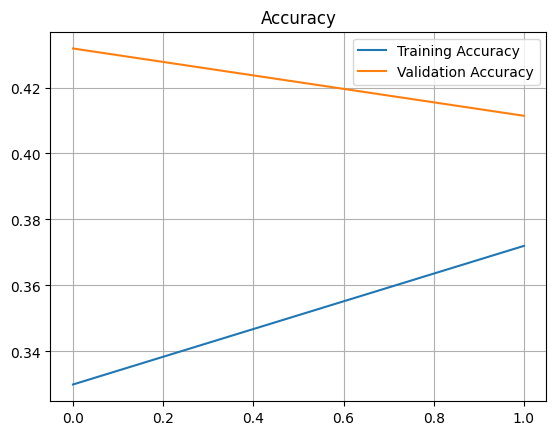

In [ ]:
# Run the first simple model again
# requires you to rerun the code-blocks from task 2 first
history, model = train_model()
plot(history)